## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import utils as u

In [2]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.drop(columns='Unnamed: 0', inplace=True)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Also the attribute file will come in handy for handling missing or unknown values
dictionary = pd.read_excel('DIAS Attributes - Values 2017_revised.xlsx', sheet_name='Tabelle1')
dictionary.drop(columns='Unnamed: 0', inplace=True)

In [4]:
column_dist = mailout_train.isnull().sum()
column_dist.sort_values(ascending=False, inplace=True)
outlier_columns = column_dist.index[:8]
print(column_dist[:30]/mailout_train.shape[0])

ALTER_KIND4       0.999046
ALTER_KIND3       0.995950
ALTER_KIND2       0.982403
ALTER_KIND1       0.953727
KK_KUNDENTYP      0.589265
EXTSEL992         0.371212
HH_DELTA_FLAG     0.225269
W_KEIT_KIND_HH    0.225269
KBA05_KW2         0.201294
MOBI_REGIO        0.201294
KBA05_KW3         0.201294
KBA05_MAXAH       0.201294
KBA05_MAXBJ       0.201294
KBA05_MAXHERST    0.201294
KBA05_MOTRAD      0.201294
KBA05_MAXVORB     0.201294
KBA05_MOD1        0.201294
KBA05_MOD2        0.201294
KBA05_MOD3        0.201294
KBA05_MOD4        0.201294
KBA05_MOD8        0.201294
KBA05_MOTOR       0.201294
KBA05_KW1         0.201294
KBA05_MAXSEG      0.201294
KBA05_ZUL2        0.201294
KBA05_SEG1        0.201294
KBA05_SEG7        0.201294
KBA05_ZUL1        0.201294
KBA05_VORB2       0.201294
KBA05_VORB1       0.201294
dtype: float64


In [5]:
cat_col = u.obtain_categorical_columns(mailout_train)
cat_col

{'multi': ['LP_FAMILIE_FEIN',
  'LP_FAMILIE_GROB',
  'LP_STATUS_FEIN',
  'LP_STATUS_GROB',
  'NATIONALITAET_KZ',
  'SHOPPER_TYP',
  'TITEL_KZ',
  'VERS_TYP',
  'CJT_GESAMTTYP',
  'CAMEO_DEUG_2015',
  'FINANZTYP',
  'GEBAEUDETYP',
  'GFK_URLAUBERTYP',
  'ZABEOTYP'],
 'binary': ['OST_WEST_KZ', 'ANREDE_KZ', 'GREEN_AVANTGARDE']}

In [6]:
unknown_dict = u.create_unknown_dictionary(dictionary)

Shape of the attribute file: (2258, 4)
Missing values in the array: 11
After filling NaNs with False: 
False    2025
True      233
Name: Meaning, dtype: int64


In [7]:
mailout_train = u.clean_mailout(mailout_train, unknown_dict, outlier_columns, cat_col)

In [8]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE,EINGEFUEGT_AM_YEAR
0,1763,2.0,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,...,0,1,0,0,0,0.0,40.0,3.0,4.0,1992.0
1,1771,1.0,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,...,0,0,0,0,0,0.0,70.0,3.0,2.0,1997.0
2,1776,1.0,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,...,0,1,0,0,0,1.0,40.0,1.0,4.0,1995.0
3,1460,2.0,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,...,0,1,0,0,0,1.0,40.0,1.0,4.0,1992.0
4,1783,2.0,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,...,0,1,0,0,0,0.0,50.0,4.0,1.0,1992.0


In [9]:
rows_dist = mailout_train.isnull().sum(axis=1)
n_columns = mailout_train.shape[1]
max_na = n_columns * 0.25
print('Maximum threshold for missing values: {}'.format(max_na))
# Lets divide the data into 2 subsets based on the number of missing values in each row, in
# this case we can use max_na as a threshold

na_rows_low = rows_dist[rows_dist < max_na]
na_rows_high = rows_dist[rows_dist >= max_na]

print(na_rows_low.shape, na_rows_high.shape)

Maximum threshold for missing values: 109.0
(35000,) (7962,)


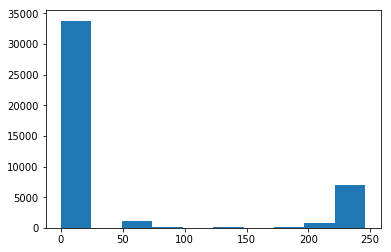

In [10]:
plt.hist(rows_dist);

In [15]:
mailout_train['RESPONSE'][mailout_train.index.isin(na_rows_high.index)].sum()
mailout_train['RESPONSE'][mailout_train.index.isin(na_rows_low.index)].sum()

435